# Week 07

Regression modeling

## Setup

Run the following 2 cells to import all necessary libraries and helpers for this week's exercises

In [1]:
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/data_utils.py

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression

from data_utils import regression_error
from data_utils import object_from_json_url

## Regression

Regression, or Regression Analysis, is a set of statistical processes for estimating the relationship between a dependent variable (sometimes called the 'outcome', 'response' or 'label') and one or more independent variables (called 'features', 'dimensions' or 'columns').

For example, let's say we have the following data about people's wages and years of experience:

<img src="./imgs/wages-exp.png" width="620px"/>

We could use regression to calculate how the values for wages are affected by years of experience in our dataset, and then create a function to more generally estimate the relation between wages and experience:

<img src="./imgs/wages-exp-fit.png" width="620px"/>

We could now estimate wages for values of years of experience that we didn't have measurements for.

This is an estimate, but the more points we use and the more features we have in our dataset the better the regression results will be.

### Setting up Regression

For a simple dataset we can perform regression by following these steps:

1. Load dataset
2. Encode label features as numbers
3. Normalize the data
4. Separate the outcome variable(s) (not scaled) and the feature variables (scaled)
5. Create a regression model
6. Run model on input data and 
7. Measure error

## Diamond Prices

Let's use the dataset from last week to set up a diamond price estimator.

Steps 1 - 3 should look familiar, and they've been pasted below:

In [3]:
## 1. Load Dataset
DIAMONDS_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025F-A/5020-utils/main/datasets/json/diamonds.json"

# Read into DataFrame
diamonds_data = object_from_json_url(DIAMONDS_FILE)
diamonds_df = pd.DataFrame.from_records(diamonds_data)


## 2. Encode non-numeric values
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

diamond_encoder = OrdinalEncoder(categories=[cut_order, color_order, clarity_order])

ccc_vals = diamond_encoder.fit_transform(diamonds_df[["cut", "color", "clarity"]].values)
diamonds_df[["cut", "color", "clarity"]] = ccc_vals


## 3. Normalize the data
diamond_scaler = StandardScaler().set_output(transform="pandas")
diamonds_scaled_df = diamond_scaler.fit_transform(diamonds_df)

In [9]:
diamonds_scaled_df.cov()["price"]

carat      0.911373
depth     -0.011289
table      0.098960
x          0.876382
y          0.877840
z          0.869846
cut       -0.013198
color     -0.112973
clarity   -0.094852
price      1.000069
Name: price, dtype: float64

### Chose Features

Now we separate the outcome variable values and the independent variables.

Let's start simple and use only one feature: `carat`.

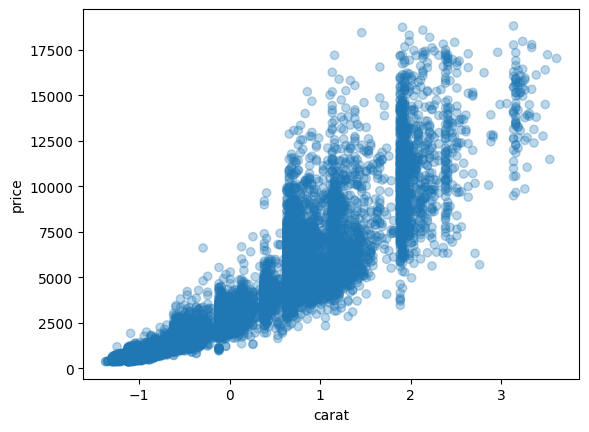

In [13]:
## 4. Separate the outcome variable and the independent variables
prices = diamonds_df[["price"]] #price is coming from unscaled so still in dollars
carats = diamonds_scaled_df[["carat"]]

# Plot the variables, just for checking
plt.scatter(carats, prices, marker='o', linestyle='', alpha=0.3)
plt.xlabel("carat")
plt.ylabel("price")
plt.show()

### Model

Let's setup and create a linear regression model.

We'll use the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object from the `Scikit-Learn` library.

Once we create an instance of a `LinearRegression` object, we can use its `fit()` function to compute the relationship between `price` and `carat` values.

In [7]:
## 5. Create a LinearRegression object
price_model = LinearRegression()

# Create a model that relates price of diamonds to their carat value
price_model.fit(carats, prices)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


We can do the creation and fitting in one line like this:

In [14]:
## 5. Create a LinearRegression object and fit with the training data
price_model = LinearRegression().fit(carats, prices)

These are the $\beta$ parameters that the model calculated for our line of best fit:

In [15]:
price_model.coef_, price_model.intercept_

(array([[3072.08384731]]), array([3512.85800439]))

### Evaluate

It's really rare for a model to perfectly capture all of the subtleties of a dataset. Models try to capture trends in the data and not all data in a dataset is gonna fit a trend.

When we run `predict()` on a dataset some/most of the predictions are gonna be off. Since we have the real values and the predicted values we can calculate how far off the predictions are.

The simplest and most obvious way to do this is to feed the features from our dataset back into our model, but this time, instead of using them to train our model, we'll compare the computed prediction values to the actual known values of the outcome variables in our dataset.

One way to formally quantify this process is to calculate the *Mean Squared Error* of our predictions, or, the average of the squares of individual errors.

It's calculated using the known values for the outcome variable $Y$, and the predicted values from our model $\hat{Y}$. For each prediction, we subtract the predicted value from the known value and square this difference. We do this for every predicted value, and sum all of these squared errors before dividing by the total number of predictions.

It can be expressed as:

$\displaystyle \frac{1}{n} \sum_{i=1}^{n}\left(Y_i - \hat{Y}_i \right)^{2}$

Luckily, the `regression_error()` function does this for us when given the $2$ lists of outcome values, $Y$ and $\hat{Y}$.

In [16]:
## 6. Run the model on the training data
predicted_prices = price_model.predict(carats)

## 7. Measure error
regression_error(diamonds_df["price"], predicted_prices)

1387.9365945007248

### Result

Hmmm.... what this means is that on average our model is wrong by $\$1388$ dollars.

We can plot our predictions with the original data:

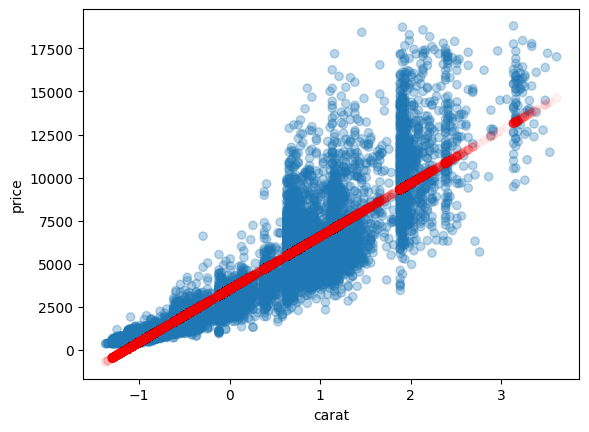

In [17]:
# Plot the original values
plt.scatter(carats, prices, marker='o', linestyle='', alpha=0.3)
plt.xlabel("carat")
plt.ylabel("price")

# Plot the predictions
plt.scatter(carats, predicted_prices, color='r', marker='o', linestyle='', alpha=0.05)
plt.xlabel("carat")
plt.ylabel("price")
plt.show()

Another way to plot this is to draw the line between the predicted values for `carat.min()` and `carat.max()`:

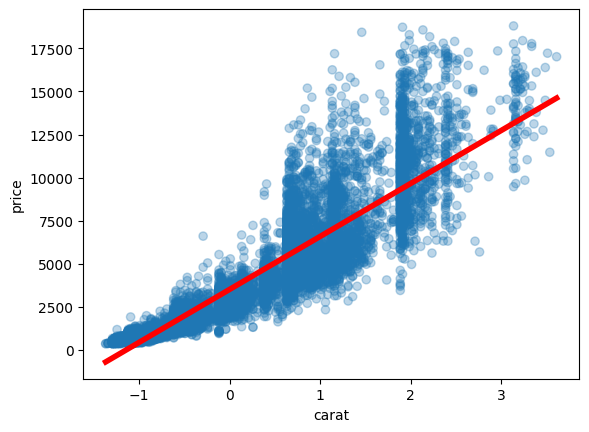

In [18]:
# Plot the original values
plt.scatter(carats, prices, marker='o', linestyle='', alpha=0.3)
plt.xlabel("carat")
plt.ylabel("price")

# Plot the line of best fit
c0,c1 = carats.min(), carats.max()
p0,p1 = price_model.coef_[0]*c0 + price_model.intercept_[0], price_model.coef_[0]*c1 + price_model.intercept_[0]

plt.plot([c0,c1], [p0,p1], color="r", linestyle="-", linewidth=4)
plt.xlabel("carat")
plt.ylabel("price")
plt.show()

### Interpretation

We're only using one variable to model the price using linear regression, so, as the name suggests, the resulting model is a line:

$\displaystyle price = \beta \cdot carat$

(This should look familiar; it's the equation for a line that we might have learned in algebra: $y = m \cdot x + b$)

$\beta$ in this equation is a constant calculated by the model. The model uses all of the values about `price` and `carat` to calculate this ONE constant that defines our line.

For every value of $carat$ the model gives us a value for $price$.

### Another Graph

Another way to visualize how far off the model is from the actual data is to look at sorted lists of prices.

So, we run the model on the input, get the resulting prices, sort them and plot them against the original sorted prices.

This is just a quick way to see if there are regions of our data where the model is wrong more often, or right more often. We can combine that information with the distribution of prices in the dataset to see if it's ok for our model to be this wrong.

We could have a situation where very rare and uncommon diamond prices (too low or too high) are contributing a large amount of error to our average error. If the predictions for the more common diamond prices are close, then maybe our model is good.

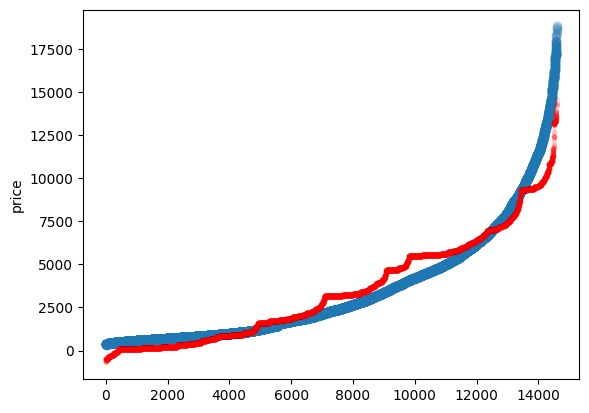

In [19]:
prices_original = diamonds_df["price"]

# Plot the original and predicted prices
plt.plot(sorted(prices_original), marker='o', linestyle='', alpha=0.3)
plt.plot(sorted(predicted_prices), color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("price")
plt.show()

### Interpretation

The model seems ok with lower priced diamonds, but anything more expensive than $\$6000$ seems to be more wrong.

Let's add features to the model.

### Using more features

Let's add a feature to build our model.

This time our model equation will have multiple independent variables:

$\displaystyle price = \beta_0 \cdot carat + \beta_1 \cdot width$

The $\beta_i$ values in this equation are constants that the model calculates. There are $2$ now, so the model has more parameters to adjust in order to get a better fit.

The overall process for preparing our data is the same, but this time we'll use `carat` and the `x` dimension of the diamonds to predict their prices.

We already have scaled features in `features_scaled_df`, so we can just pick our input features from there.

In [20]:
## 4. Separate the outcome variable and the independent variables
prices = diamonds_df[["price"]]
features = diamonds_scaled_df[["carat", "x"]]

## 5. Create a LinearRegression object and
# fit a model that relates price of diamonds to their carat value as well as width and length
price_model = LinearRegression().fit(features, prices)

## 6. Run the model on the training data
predicted_prices = price_model.predict(features)

## 7. Measure error
regression_error(diamonds_df["price"], predicted_prices)

1329.202775480908

The $\beta$ parameters computed:

In [21]:
price_model.coef_, price_model.intercept_

(array([[ 5310.85708907, -2274.1357919 ]]), array([3512.85800439]))

### Result

This is marginally better. The error decreased very slightly.

We can plot our new model predictions using a $3D$ plot to look at how price varies along with the `carat` and `width` of the diamonds:

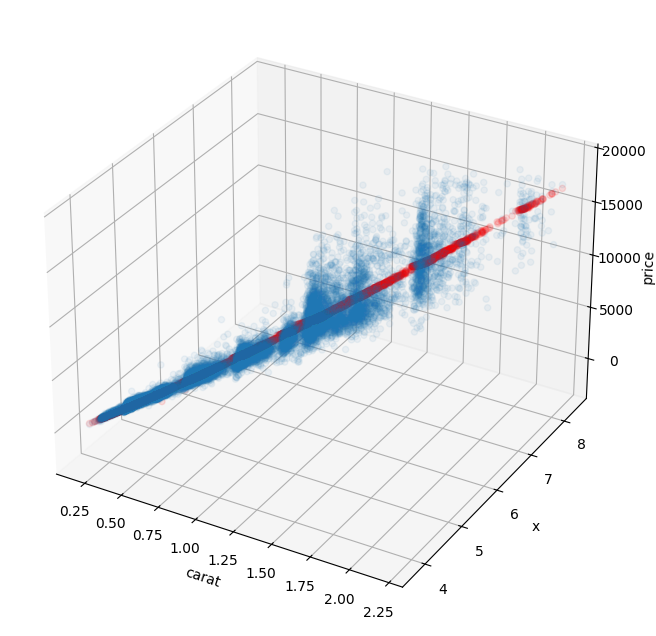

In [24]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

cs = diamonds_df[["carat"]].values
xs = diamonds_df[["x"]].values

ps = diamonds_df[["price"]].values
pps = predicted_prices

ax.scatter(cs, xs, ps, marker='o', linestyle='', alpha=0.06)
ax.scatter(cs, xs, pps, color='r', marker='o', linestyle='', alpha=0.1)

ax.set_xlabel('carat')
ax.set_ylabel('x')
ax.set_zlabel('price')

plt.show()

Our line of best fit is still a line. Why?

Let's visualize our model by calculating the predicted prices at the smallest and largest values of `carat` and `width`:

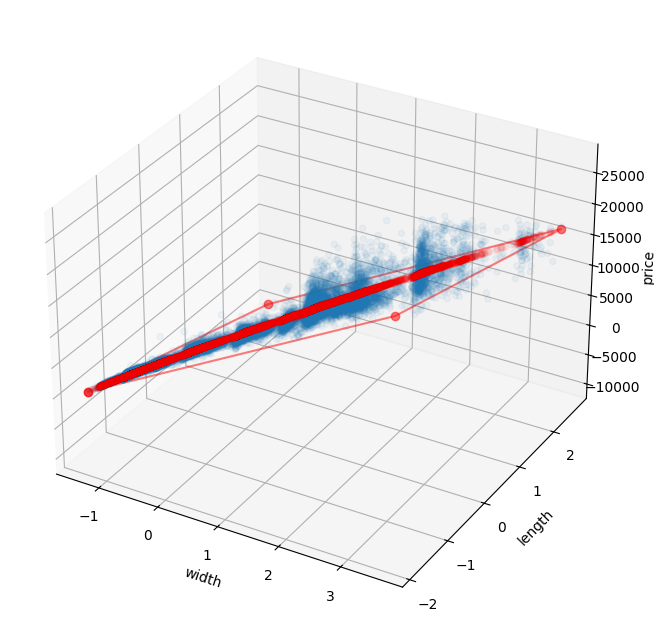

In [25]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

cs = diamonds_scaled_df[["carat"]].values
xs = diamonds_scaled_df[["x"]].values

ps = diamonds_df[["price"]].values
pps = predicted_prices

ax.scatter(cs, xs, ps, marker='o', linestyle='', alpha=0.05)
ax.scatter(cs, xs, pps, color='r', marker='o', linestyle='', alpha=0.05)

csmm = [cs.min(), cs.max(), cs.max(), cs.min(), cs.min()]
xsmm = [xs.min(), xs.min(), xs.max(), xs.max(), xs.min()]

ppsmm = [
  price_model.coef_[0][0] * csmm[i] + price_model.coef_[0][1] * xsmm[i] + price_model.intercept_[0] for i in range(len(xsmm))
]
ax.plot(csmm, xsmm, ppsmm, color='r', marker='o', linestyle='-', alpha=0.5)
ax.set_xlabel('width')
ax.set_ylabel('length')
ax.set_zlabel('price')

plt.show()

We can see that when we use $2$ parameters, the model finds a solutions in larger space, but the model still predicts a line.

It's just that now that line lies on a plane through our input range.

### Using more features

Let's use a few more features to build our model.

This time our model equation will have $3$ independent variables:

$\displaystyle price = \beta_0 \cdot carat + \beta_1 \cdot width + \beta_2 \cdot length$

Again, the $\beta_i$ values in this equation are constants that the model will calculate for us.

The overall process for preparing our data is the same, but this time we'll use `carat` along with the `x` and `y` dimensions of the diamond to predict prices.

In [26]:
## 4. Separate the outcome variable and the independent variables
prices = diamonds_df[["price"]]
features = diamonds_scaled_df[["carat", "x", "y"]]

## 5. Create a LinearRegression object and fit it with training data (carat, width and length)
price_model = LinearRegression().fit(features, prices)

## 6. Run the model on the training data
predicted_prices = price_model.predict(features)

## 7. Measure error
regression_error(diamonds_df["price"], predicted_prices)

1324.3058491942982

The $\beta$ parameters computed:

In [27]:
price_model.coef_, price_model.intercept_

(array([[ 5271.29513075, -4145.47146363,  1913.69311999]]),
 array([3512.85800439]))

### Result

This is getting better. The more features we give the model, the better it's able to find a line/plane/hyperplane to represent the price variable.

We can plot our new model, but since we humans are limited to $3$ physical dimensions that we can comprehend, we can't plot price as a function of all $3$ of our features.

We'll create a $3D$ plot that to look at how price varies along with the length and width of the diamonds:

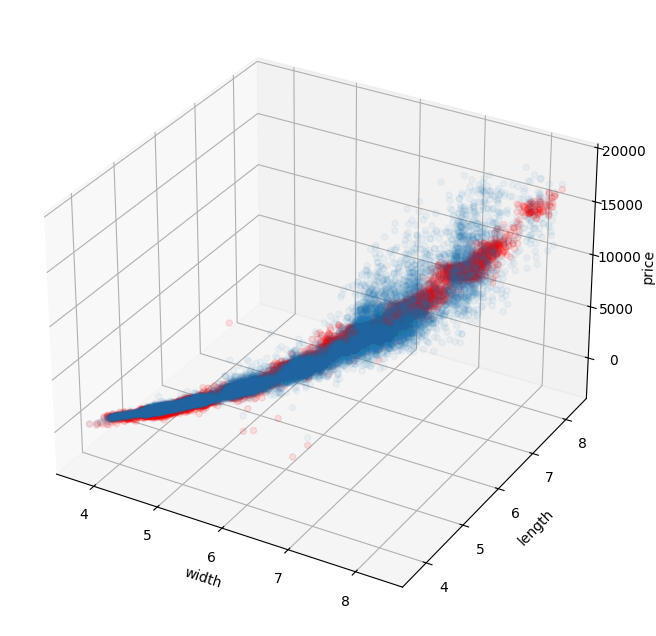

In [28]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

xs = diamonds_df[["x"]].values
ys = diamonds_df[["y"]].values

ps = diamonds_df[["price"]].values
pps = predicted_prices

ax.scatter(xs, ys, ps, marker='o', linestyle='', alpha=0.05)
ax.scatter(xs, ys, pps, color='r', marker='o', linestyle='', alpha=0.1)

ax.set_xlabel('width')
ax.set_ylabel('length')
ax.set_zlabel('price')

plt.show()

### Using ALL features

Let's use all $9$ features from the dataset to build our model.

The model equation will be something like:

$\displaystyle price = \beta_0 \cdot x_0 + \beta_1 \cdot x_1 + ... + \beta_8 \cdot x_8$

Where the $x_i$ values are the values of our features (`carat`, `width`, etc) and the $\beta_i$ parameters are the constant values that the model will calculate.

Repeat the steps below, but this time using all of the features in our dataset:

In [29]:
diamonds_scaled_df.head()

,carat,depth,table,x,y,z,cut,color,clarity,price
0,-0.592179,-0.262475,0.746416,-0.525062,-0.472275,-0.524673,-0.864375,0.917209,1.162671,-0.386186
1,-1.092989,-2.127327,1.671437,-1.151859,-1.191637,-1.363730,0.054267,-0.873042,-0.063041,-0.868230
2,-1.092989,0.334278,-1.103625,-1.259590,-1.221200,-1.205418,0.972910,-0.276291,2.388383,-0.777754
3,0.083914,-1.306792,-0.641115,0.356371,0.385048,0.203566,-0.864375,0.917209,0.549815,0.026147
4,-0.867624,0.334278,-0.641115,-0.867842,-0.925572,-0.857130,0.972910,-0.873042,1.162671,-0.708340


In [31]:
# TODO: repeat steps for training a predictor on all features
prices = diamonds_df[["price"]]
features = diamonds_scaled_df.drop(columns = ["price"])
## 5. Create a LinearRegression object and fit it with training data (carat, width and length)
price_model = LinearRegression().fit(features, prices)

## 6. Run the model on the training data
predicted_prices = price_model.predict(features)

## 7. Measure error
regression_error(diamonds_df["price"], predicted_prices)


1015.0836021399659

### Result

The error should have gotten better.

Let's sort and plot all of the prices from the original dataset and the reconstructed prices from our model.

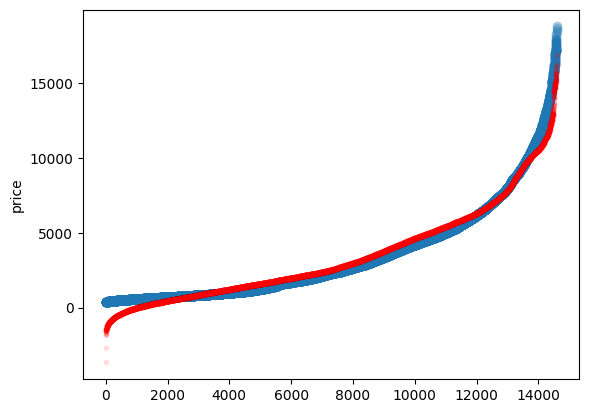

In [32]:
prices_original = diamonds_df["price"]

# Plot the original and predicted prices
plt.plot(sorted(prices_original), marker='o', linestyle='', alpha=0.3)
plt.plot(sorted(predicted_prices), color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("price")
plt.show()

### Interpretation

This is another one of these graphs of sorted prices that can be used to see the distribution of prices from the dataset and compare it to the prices from the model.

Depending on where on the distribution our error comes from, we can have an ok model with large errors, as long as the errors are in regions that aren't common.

In this case, there is some pretty constant error throughout the modeled prices.

The error is even worse for diamonds on the extreme ends of price: the too cheap and too expensive ones.

And since even a small percentage of error for an expensive diamond contributes to a large error in dollars, this is probably where a lot of the error is coming from.

### Even MORE Features !

One trick to improve our model is to create some extra features from the current ones.

For example, in addition to considering `carat` and `width` of each diamond separately, we can create a feature that is a combination of these two values.

Considering just those $2$ features, instead of having an equation that is like this:

$\displaystyle price = \beta_0 \cdot carat + \beta_1 \cdot width$

We can try to model an equation that has quadratic terms, like this:

$\displaystyle price = \beta_0 \cdot carat + \beta_1 \cdot width + \beta_2 \cdot carat^2 + \beta_3 \cdot width^2 + \beta_4 \cdot carat \cdot width$

Or even cubic terms:

$\displaystyle price = \beta_0 \cdot carat + \beta_1 \cdot width + \beta_2 \cdot carat^2 + \beta_3 \cdot width^2 + \beta_4 \cdot carat \cdot width + \beta_5 \cdot carat^3 + \beta_6 \cdot width^3$

This allows our model to figure out more complex relationships between the features and consider non-linear relationships between features and price (maybe `price` goes up proportional to the square of the `width` of the diamond).

Scikit-Learn has an object called [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) that helps us do exactly this. We just have to instantiate it and use it to create some extra features for us.

The process of using it should loo familiar by now: instantiate an object, use its `fit_transform()` function on our features to get a new version of our data, use the new data, success.

In [ ]:
## 4. Separate the outcome variable and the independent variables
prices = diamonds_df[["price"]]
features = diamonds_scaled_df.drop(columns=["price"])

## 4B. Create extra features
poly = PolynomialFeatures(degree=3, include_bias=False).set_output(transform="pandas")
    # degrees sets max number we can raise a variable to - in this case only considering the cube of our independents at max
    #this will consider every feature, its square, and its cube
features_poly = poly.fit_transform(features)



## 5. Create a LinearRegression object and fit it with training data
price_model = LinearRegression().fit(features_poly, prices)

## 6. Run the model on the training data
predicted_prices = price_model.predict(features_poly)

## 7. Measure error
regression_error(diamonds_df["price"], predicted_prices)

465.4388480819173

In [51]:
features_poly.head()

,carat,depth,table,x,y,z,cut,color,clarity,carat^2,...,cut^3,cut^2 color,cut^2 clarity,cut color^2,cut color clarity,cut clarity^2,color^3,color^2 clarity,color clarity^2,clarity^3
0,-0.592179,-0.262475,0.746416,-0.525062,-0.472275,-0.524673,-0.864375,0.917209,1.162671,0.350676,...,-0.645812,0.685287,0.868682,-0.727174,-0.921780,-1.168465,0.771622,0.978123,1.239887,1.571704
1,-1.092989,-2.127327,1.671437,-1.151859,-1.191637,-1.363730,0.054267,-0.873042,-0.063041,1.194625,...,0.000160,-0.002571,-0.000186,0.041363,0.002987,0.000216,-0.665434,-0.048050,-0.003470,-0.000251
2,-1.092989,0.334278,-1.103625,-1.259590,-1.221200,-1.205418,0.972910,-0.276291,2.388383,1.194625,...,0.920910,-0.261524,2.260731,0.074269,-0.642013,5.549841,-0.021091,0.182322,-1.576070,13.624235
3,0.083914,-1.306792,-0.641115,0.356371,0.385048,0.203566,-0.864375,0.917209,0.549815,0.007042,...,-0.645812,0.685287,0.410791,-0.727174,-0.435900,-0.261297,0.771622,0.462544,0.277269,0.166207
4,-0.867624,0.334278,-0.641115,-0.867842,-0.925572,-0.857130,0.972910,-0.873042,1.162671,0.752772,...,0.920910,-0.826380,1.100530,0.741553,-0.987562,1.315183,-0.665434,0.886190,-1.180181,1.571704


### Result

This is significantly better than our original model.

Let's sort and plot the resulting prices again:

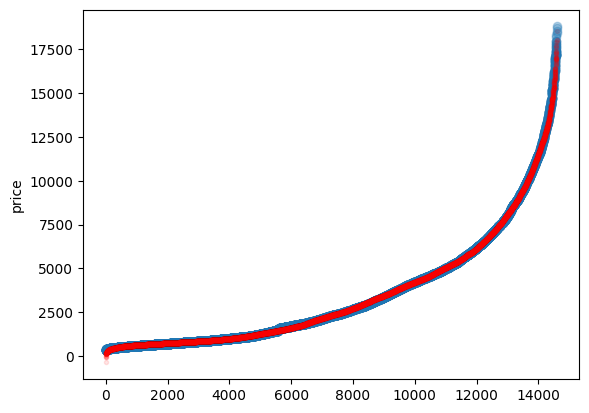

In [34]:
# Plot sorted prices
prices_original = sorted(diamonds_df["price"])
prices_predicted = sorted(predicted_prices)

# Plot the original and predicted prices
plt.plot(prices_original, marker='o', linestyle='', alpha=0.3)
plt.plot(prices_predicted, color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("price")
plt.show()

And this looks good, except for very cheap and very expensive diamonds.

### More plots

And since we can't see in 4D or 5D yet, let's just plot `price` as a function of a few individual features.

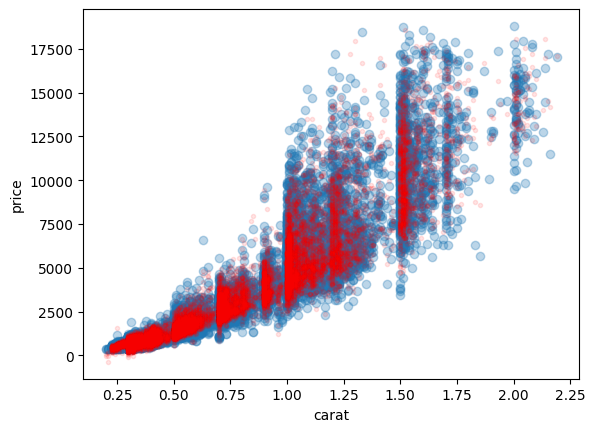

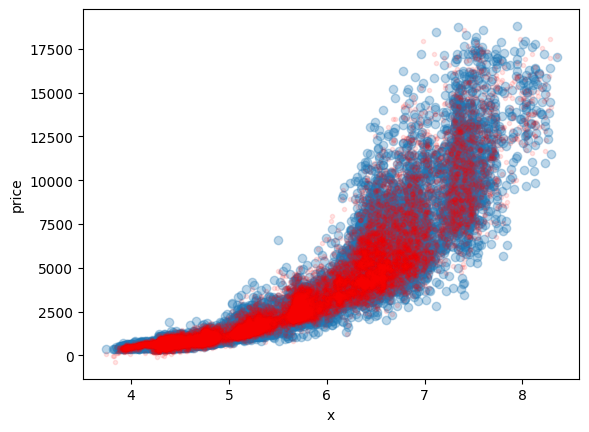

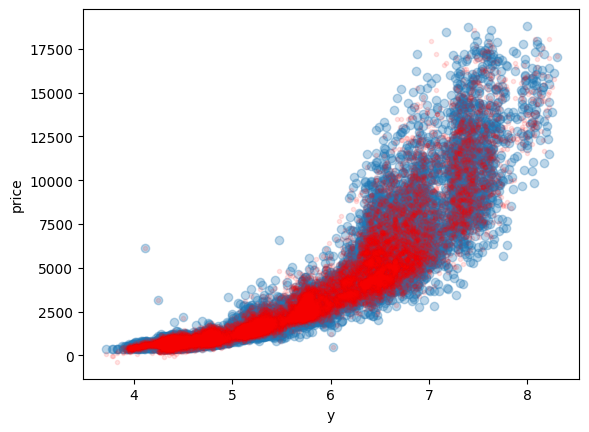

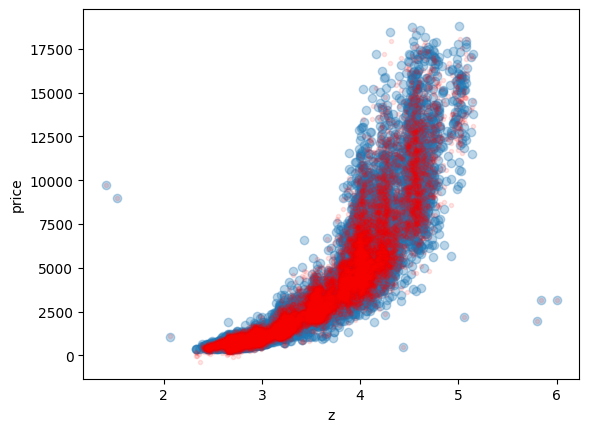

In [35]:
# Plot price vs carat, x, y and z
for feat in ["carat", "x", "y", "z"]:
  x = diamonds_df[feat]
  prices_original = diamonds_df["price"]
  prices_predicted = predicted_prices

  # Plot the original and predicted prices
  plt.plot(x, prices_original, marker='o', linestyle='', alpha=0.3)
  plt.plot(x, prices_predicted, color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
  plt.xlabel(feat)
  plt.ylabel("price")
  plt.show()

# 🎉🍾

These look ok. We have a nice model for diamond prices.

## More Non-Linear Linear Regression!

This is just a quick aside into the world of _**feature engineering**_, which is the process of carefully adding data to our dataset, based on data we already have.

Let's repeat the process of linear regression for a new dataset for monthly diamond sales.

We'll follow the same steps as before:
1. Load data
2. Encode
3. Normalize
4. Choose features
5. Create model
6. Test model on input data
7. Measure error and analyze results

In [36]:
## 1. Load Dataset
SALES_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025F-A/5020-utils/main/datasets/json/diamond_sales.json"

# Read into DataFrame
sales_data = object_from_json_url(SALES_FILE)
sales_df = pd.DataFrame.from_records(sales_data)

# Look at features: values, types, names, min, max, mean
for c in sales_df.columns:
  print(c, "\n\tmin:", sales_df[c].min())
  print("\tmax:", sales_df[c].max())
  print("\tavg:", round(sales_df[c].mean(), 3))
  print("\tstd:", round(sales_df[c].std(), 3))

sales_df.head()

month 
	min: 0
	max: 119
	avg: 59.5
	std: 34.785
sales 
	min: 1089
	max: 5735
	avg: 3418.633
	std: 1022.59


,month,sales
0,0,1392
1,1,2522
2,2,2850
3,3,4510
4,4,4397


This is a much simpler dataset with only one feature: `month`, and one outcome: `sales`.

We can easily plot all of the data just to check for any trends or specificities:

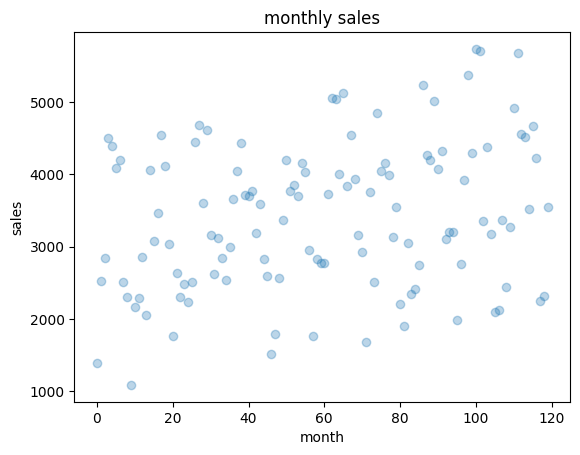

In [37]:
plt.plot(sales_df["month"], sales_df["sales"], marker='o', linestyle='', alpha=0.3)
plt.title("monthly sales")
plt.xlabel("month")
plt.ylabel("sales")
plt.show()

Looks like diamond sales to me !

Despite the spread of sale amounts between $\$1000$ and $\$6000$, we can kind of notice a slightly upward trend.

Let's check with a model.

### Model

Let's do linear regression to predict future diamond sales amounts.

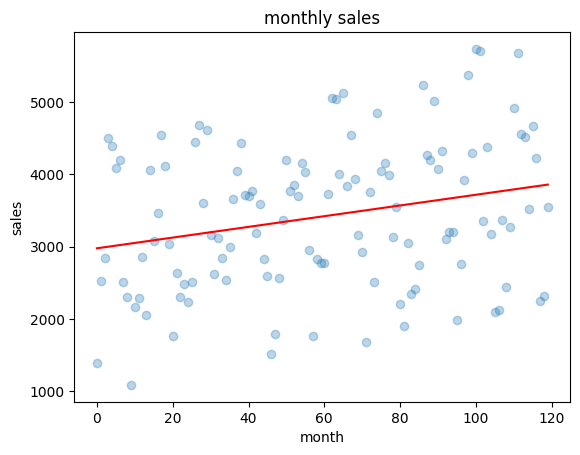

985.5240696317496

In [44]:
# TODO: train a Linear Regression predictor for sales based on month

## 3. Normalize: we only have one input. No need.
## 4. Separate the outcome variable and the independent variables
sales = sales_df[["sales"]]
features = sales_df[["month"]]

## 5. Create a LinearRegression object and fit a model that relates sales amounts to month
price_model = LinearRegression().fit(features, sales)

## 6. Run the model on the training data
predicted_sales = price_model.predict(features)

## 7. Measure error
regression_error(sales_df["sales"], predicted_sales)

# Plot predictions
plt.plot(sales_df["month"], sales_df["sales"], marker='o', linestyle='', alpha=0.3)
plt.plot(sales_df["month"], predicted_sales, marker='', color='r')
plt.title("monthly sales")
plt.xlabel("month")
plt.ylabel("sales")
plt.show()


regression_error(sales_df["sales"], predicted_sales)

There's our slight upward trend... and almost $\$1000$ of average error.

### Why we look at data

Let's say that when we first plotted our data, instead of plotting dots with:

```py
plt.plot(sales_df["month"], sales_df["sales"], marker='o', linestyle='', alpha=0.3)
```

we left out some of the parameters and plotted this instead:

```py
plt.plot(sales_df["month"], sales_df["sales"], alpha=0.3)
```

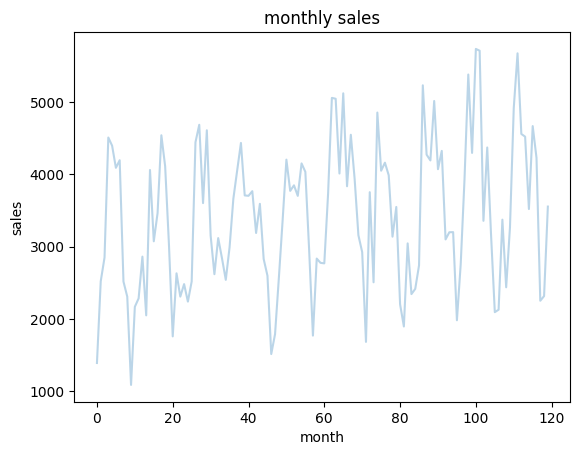

In [45]:
plt.plot(sales_df["month"], sales_df["sales"], alpha=0.3)
plt.title("monthly sales")
plt.xlabel("month")
plt.ylabel("sales")
plt.show()

### Same Data, Different Story

We can now see that the ups and downs in the sales amounts aren't random, but probably correlate with the months of the year.

Whenever we want to model data like this, we have to add a special type of feature to our data in order to capture the ups and downs of cyclic, periodic values.

Just like we added new quadratic and cubic features to our linear regression equation, like this:

$\displaystyle sales = \beta_0 \cdot month + \beta_1 \cdot month^{2} + \beta_2 \cdot month^{3}$

We can add a periodic feature by using periodic functions like `sin()` and `cos()`:

$\displaystyle sales = \beta_0 \cdot month + \beta_1 \cdot \sin(month)$

We just have to define a function and then create a new column in our `DataFrame` based on this function:

In [46]:
from math import sin, pi

# function with a period of 12 (months)
def sinx(x):
  return sin(2 * x * pi / 12.0)

# create a new column called "periodic_month" by applying sinx() to all values of month
sales_df["periodic_month"] = sales_df["month"].apply(sinx)

### Re-Model

Everything from now on is the same. We can even copy+paste the code from above:

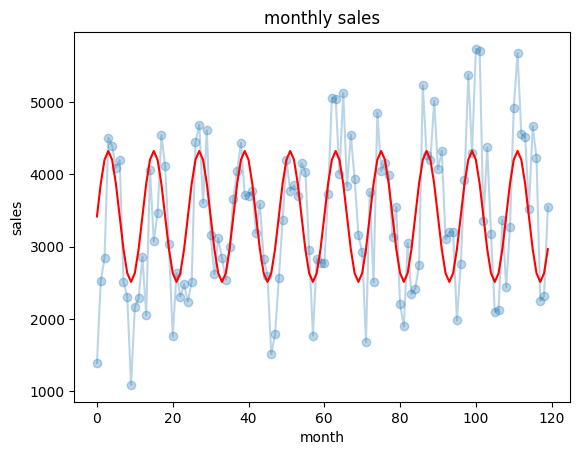

791.9808664388609

In [49]:
# TODO: train a Linear Regression predictor for sales based on month

## 3. Normalize: we only have one input. No need.
## 4. Separate the outcome variable and the independent variables
sales = sales_df[["sales"]]
features = sales_df[["periodic_month"]]

## 5. Create a LinearRegression object and fit a model that relates sales amounts to month
price_model = LinearRegression().fit(features, sales)

## 6. Run the model on the training data
predicted_sales = price_model.predict(features)

## 7. Measure error
regression_error(sales_df["sales"], predicted_sales)

# Plot predictions
plt.plot(sales_df["month"], sales_df["sales"], marker='o', linestyle='-', alpha=0.3)
plt.plot(sales_df["month"], predicted_sales, marker='', color='r')
plt.title("monthly sales")
plt.xlabel("month")
plt.ylabel("sales")
plt.show()
regression_error(sales_df["sales"], predicted_sales)

And, just like that, our model's error got better.

## More Regression!

Let's do one more regression exercise using a different dataset.

This one is for wine quality.

In [ ]:
## 1. Load Dataset
WINE_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025F-A/5020-utils/main/datasets/json/wines.json"

# Read into DataFrame
wines_data = object_from_json_url(WINE_FILE)
wines_df = pd.DataFrame.from_records(wines_data)

# Look at features: values, types, names, etc
wines_df.head()

### Repeat some of the steps above to analyze the data

Specifically, steps $3$: normalize and look at the covariance matrix using `quality` as the independent variable of interest.

In [ ]:
# TODO: normalize and look at covariance matrix

## 3. Normalize

In [ ]:
# TODO: Since this is a new dataset, let's peek at its covariance matrix

### Plot

Looks like `alcohol`, `density`, `chlorides` and `volatility` are the $4$ features that mostly contribute to the quality.

Let's look at graphs of `quality` as a function of these $4$ features.

This could be two $3D$ graphs of pairs of variables, but four $2D$ graphs is probably easier to read.

In [ ]:
# plot quality as a function of alcohol, acidity, density and chlorides
for feat in ["alcohol", "density", "chlorides", "volatility"]:
  plt.plot(wines_scaled_df[feat], wines_df["quality"], marker="o", color="r", linestyle="", alpha=0.4)
  plt.xlabel(feat)
  plt.ylabel("quality")
  plt.show()

### Regression

Use the method above that we used in the diamond dataset to create a model that predicts wine `quality` as a function of **ALL** of its other features.

Use all of our features to run regression.

In [ ]:
# TODO: Create a linear model and run regression

## 4. Separate the outcome variable and the independent variables
## 4B. Polynomial features
## 5. Create a LinearRegression object and fit it with the training poly features
## 6. Run the model on the training data
## 7. Measure error

### Plot Results

On average our predictions are within $0.57$ points of the real quality values.

Run the cell below to look at some plots of our predictions. This assumes the predictions are in a variable called `predicted_quality`. Adjust if necessary.

In [ ]:
# Plot quality vs alcohol and volatile acidity
for feat in ["alcohol", "density", "chlorides", "volatility"]:
  x = wines_df[feat]
  quality_original = wines_df["quality"]

  # Plot the original quality
  plt.plot(x, quality_original, marker='o', linestyle='', alpha=0.3)
  plt.plot(x, predicted_quality, color='r', marker='o', linestyle='', alpha=0.3)
  plt.xlabel(feat)
  plt.ylabel("quality")
  plt.show()

### Interpretation

# 🤔

Hmm.... these could be better.

Our model wasn't able to capture the fact that the calculated `quality` value should be a discrete value and not a number with decimals.

This is because our `quality` category is not continuous, and instead can only have particular discrete values.

Instead of trying to calculate continuous values for `quality`, our model should really be trying to put the wines in the right `quality` category.

Let's use a different type of model for this task.

Instead of learning how to predict a continuous value from the independent variables, like this:

<img src="./imgs/wages-exp-fit.png" width="620px"/>

Our model should learn how to place data points into discrete groups, like this:

<img src="./imgs/wages-exp-classes.png" width="620px"/>